In [1]:
%pylab inline
import pandas as pd
import anndata
import plotnine as p

from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
from scvi.dataset import AnnDatasetFromAnnData

Populating the interactive namespace from numpy and matplotlib


In [2]:
adata = anndata.read('GSE102827_merged_all_raw.h5ad')

In [3]:
adata = adata[adata.obs.query('maintype != "nan"').index].copy()

In [4]:
adata

AnnData object with n_obs × n_vars = 48266 × 25187
    obs: 'stim', 'sample', 'maintype', 'celltype', 'subtype'

In [5]:
adata.obs['sample_idx'] = adata.obs['sample'].cat.codes

In [6]:
adata.obs['Slc17a7_counts'] = adata[:, 'Slc17a7'].X.toarray()[:, 0]
adata.obs['Olig1_counts']   = adata[:,   'Olig1'].X.toarray()[:, 0]
adata.obs['Nr4a2_counts']   = adata[:,   'Nr4a2'].X.toarray()[:, 0]

In [7]:
# Plot the observed counts of the three example genes

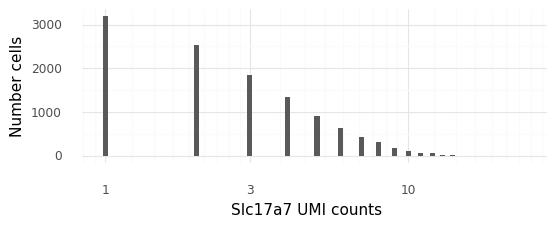

<ggplot: (-9223371866192223080)>

In [8]:
g = 'Slc17a7'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(stat='identity')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)

plot_.save('1.pdf', verbose=False)
plot_

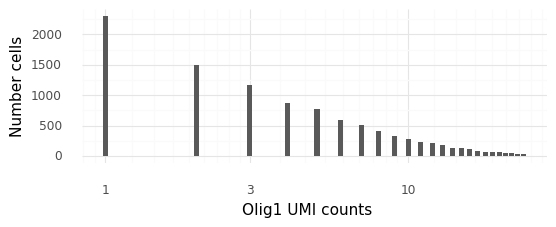

<ggplot: (-9223371866240869064)>

In [9]:
g = 'Olig1'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(stat='identity')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)

plot_.save('2.pdf', verbose=False)
plot_

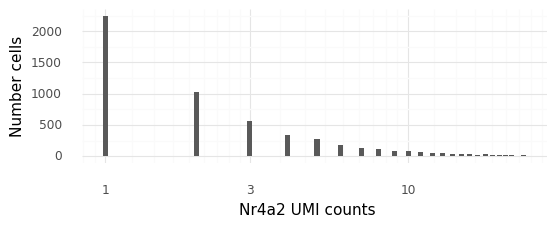

<ggplot: (-9223371866240171340)>

In [10]:
g = 'Nr4a2'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(stat='identity')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)

plot_.save('3.pdf', verbose=False)
plot_

In [11]:
# Fit scVI model

In [12]:
dataset = AnnDatasetFromAnnData(adata, batch_label='sample_idx')

[2020-09-15 22:37:20,694] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-15 22:37:20,698] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-15 22:37:22,149] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-15 22:37:22,544] INFO - scvi.dataset.dataset | Downsampled from 48266 to 48266 cells


In [13]:
vae = VAE(
    dataset.nb_genes, 
    n_batch=dataset.n_batches,
    n_layers=3,
    n_hidden=128,
    reconstruction_loss='nb'
)

In [14]:
trainer = UnsupervisedTrainer(
    vae,
    dataset,
    n_epochs_kl_warmup=None,
    frequency=1,
    use_cuda=True
)

In [15]:
trainer.train(n_epochs=25)

[2020-09-15 22:37:36,864] INFO - scvi.inference.inference | Training without KL warmup
training: 100%|████████████████████████████████████████████████████████████████████████| 25/25 [10:42<00:00, 25.70s/it]


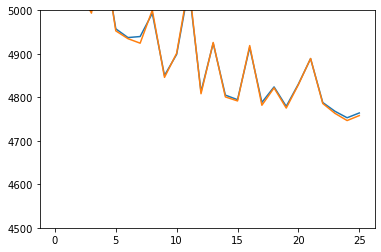

In [16]:
figsize(6, 4)
plt.plot(trainer.history['elbo_train_set'])
plt.plot(trainer.history['elbo_test_set']);
plt.ylim(ymax=5000, ymin=4500);

In [17]:
full_posterior = trainer.create_posterior()

In [18]:
# Extract integrated cell representation

In [19]:
Z = full_posterior.get_latent()[0]

In [20]:
from openTSNE import TSNE

In [21]:
tsne = TSNE(verbose=True)

In [22]:
y = tsne.fit(Z)

C:\Users\vale\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


--------------------------------------------------------------------------------
TSNE(callbacks=None, callbacks_every_iters=50, dof=1, early_exaggeration=12,
     early_exaggeration_iter=250, exaggeration=None, final_momentum=0.8,
     initial_momentum=0.5, initialization='pca', ints_in_interval=1,
     learning_rate='auto', max_grad_norm=None, metric='euclidean',
     metric_params=None, min_num_intervals=50, n_components=2,
     n_interpolation_points=3, n_iter=500, n_jobs=1,
     negative_gradient_method='fft', neighbors=None, perplexity=30,
     random_state=None, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 24.66 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.88 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeratio

In [23]:
for i, yy in enumerate(y.T):
    adata.obs[f'tsne_{i}'] = yy

In [24]:
# Plot cell representation tSNE

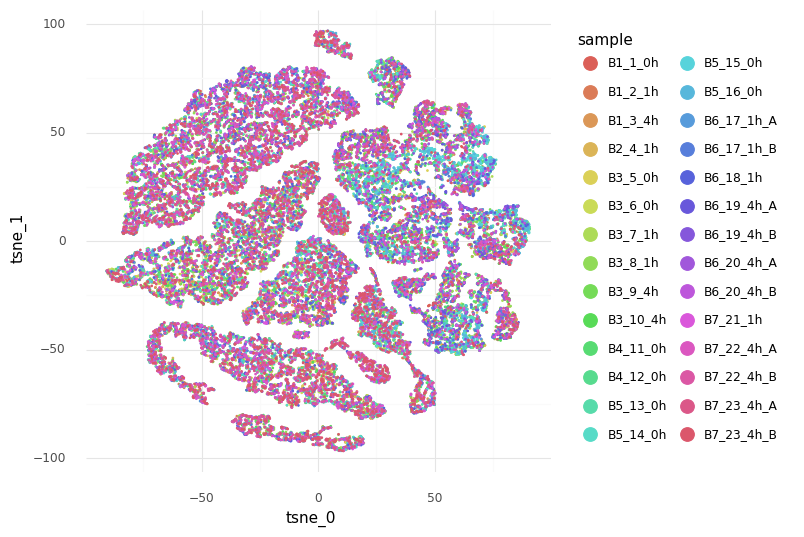

<ggplot: (-9223371866235987868)>

In [25]:
p.options.figure_size = 6, 6
plot_ = (
    p.ggplot(p.aes('tsne_0', 'tsne_1', color='sample'), adata.obs)
    + p.geom_point(size=0.1)
    + p.guides(
        color=p.guide_legend(override_aes={'size': 5}),
        alpha=p.guide_legend(override_aes={'size': 5})
    )
    + p.theme_minimal()
)
plot_.save('4.pdf', verbose=False)
plot_

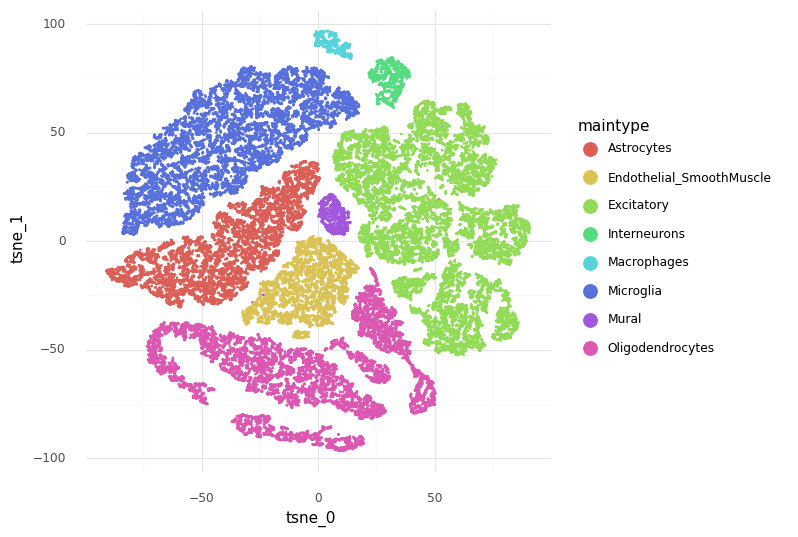

<ggplot: (-9223371865936576936)>

In [26]:
p.options.figure_size = 6, 6
plot_ = (
    p.ggplot(p.aes('tsne_0', 'tsne_1', color='maintype'), adata.obs)
    + p.geom_point(size=0.1)
    + p.guides(
        color=p.guide_legend(override_aes={'size': 5}),
        alpha=p.guide_legend(override_aes={'size': 5})
    )
    + p.theme_minimal()
)
plot_.save('5.pdf', verbose=False)
plot_

In [27]:
# Extract conditional representation

In [28]:
import torch
from scvi.models.utils import one_hot

In [29]:
px_conditional = []
for tensors in full_posterior.sequential():
    sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
    x_ = torch.log(1 + sample_batch)
    qz_m, qz_v, z = full_posterior.model.z_encoder(x_)
    ql_m, ql_v, library = full_posterior.model.l_encoder(x_)
    px = full_posterior.model.decoder.px_decoder(qz_m, batch_index)
    px_conditional.append(px.detach().cpu().numpy())

In [30]:
px_conditional = np.vstack(px_conditional)

In [31]:
tsne = TSNE(verbose=True, n_jobs=-1)
YY = tsne.fit(px_conditional)

C:\Users\vale\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


--------------------------------------------------------------------------------
TSNE(callbacks=None, callbacks_every_iters=50, dof=1, early_exaggeration=12,
     early_exaggeration_iter=250, exaggeration=None, final_momentum=0.8,
     initial_momentum=0.5, initialization='pca', ints_in_interval=1,
     learning_rate='auto', max_grad_norm=None, metric='euclidean',
     metric_params=None, min_num_intervals=50, n_components=2,
     n_interpolation_points=3, n_iter=500, n_jobs=-1,
     negative_gradient_method='fft', neighbors=None, perplexity=30,
     random_state=None, theta=0.5, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 8.23 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.59 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.18 seconds
===> Running optimization with exaggeratio

In [32]:
for i, yy in enumerate(YY.T):
    adata.obs[f'tsne_conditional_{i}'] = yy

In [33]:
# Plot tSNE of conditional representation of cells

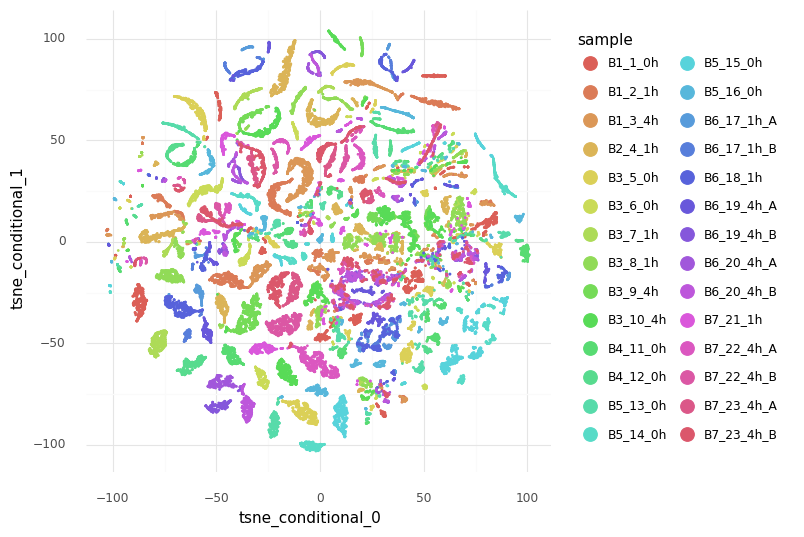

<ggplot: (-9223371865938496316)>

In [34]:
p.options.figure_size = 6, 6
plot_ = (
    p.ggplot(p.aes('tsne_conditional_0', 'tsne_conditional_1', color='sample'), adata.obs)
    + p.geom_point(size=0.1)
    + p.guides(
        color=p.guide_legend(override_aes={'size': 5}),
        alpha=p.guide_legend(override_aes={'size': 5})
    )
    + p.theme_minimal()
)
plot_.save('6.pdf', verbose=False)
plot_

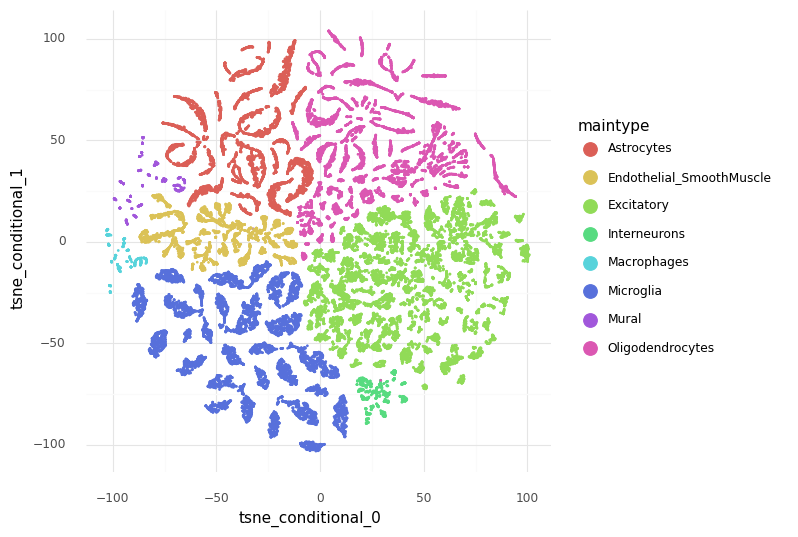

<ggplot: (-9223371865938372960)>

In [35]:
p.options.figure_size = 6, 6
plot_ = (
    p.ggplot(p.aes('tsne_conditional_0', 'tsne_conditional_1', color='maintype'), adata.obs)
    + p.geom_point(size=0.1)
    + p.guides(
        color=p.guide_legend(override_aes={'size': 5}),
        alpha=p.guide_legend(override_aes={'size': 5})
    )
    + p.theme_minimal()
)
plot_.save('7.pdf', verbose=False)
plot_

C:\Users\vale\Anaconda3\lib\site-packages\plotnine\scales\scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.
  PlotnineWarning


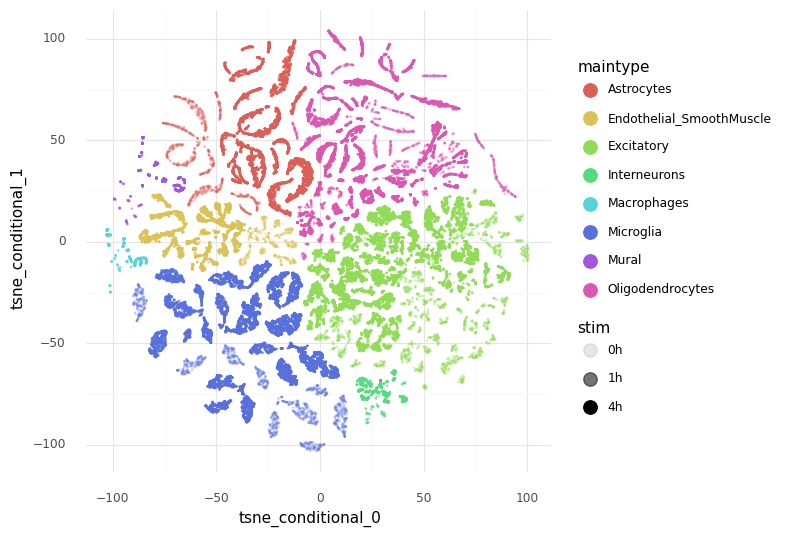

<ggplot: (-9223371865935674332)>

In [36]:
p.options.figure_size = 6, 6
(
    p.ggplot(p.aes('tsne_conditional_0', 'tsne_conditional_1', color='maintype', alpha='stim'), adata.obs)
    + p.geom_point(size=0.1)
    + p.guides(
        color=p.guide_legend(override_aes={'size': 5}),
        alpha=p.guide_legend(override_aes={'size': 5})
    )
    + p.theme_minimal()
)

In [37]:
gene_mask = (
    full_posterior
    .gene_dataset
    ._get_genes_filter_mask_by_attribute(['Slc17a7', 'Olig1', 'Nr4a2'], return_data=False)
)

In [38]:
# Get decoded representation of gene expression prior to softmax

In [39]:
px_decode = full_posterior.model.decoder.px_decoder
px_scale_decode = full_posterior.model.decoder.px_scale_decoder[0]

posterior_representation = []
for tensors in full_posterior.sequential(batch_size=2000):
    sample_batch, _, _, batch_index, labels = tensors
    outputs = full_posterior.model.inference(
        sample_batch,
        batch_index=batch_index,
        y=labels
    )
    
    pX = px_decode(outputs['qz_m'], batch_index)
    posterior_representation.append(px_scale_decode(pX)[..., gene_mask].cpu().detach().numpy())

posterior_representation = pd.DataFrame(
    np.vstack(posterior_representation),
    columns=full_posterior.gene_dataset.gene_names[gene_mask]
)

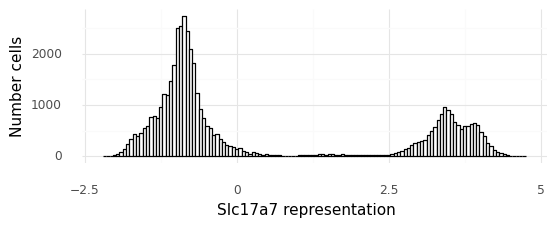

<ggplot: (-9223371866240177464)>

In [40]:
g = 'Slc17a7'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_representation)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.theme_minimal()
    + p.labs(x=f'{g} representation', y='Number cells')
)
plot_.save('8.pdf', verbose=False)
plot_

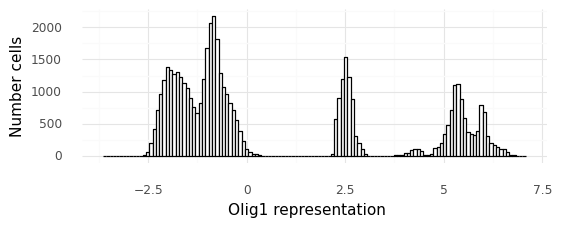

<ggplot: (-9223371866240680524)>

In [41]:
g = 'Olig1'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_representation)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.theme_minimal()
    + p.labs(x=f'{g} representation', y='Number cells')
)
plot_.save('9.pdf', verbose=False)
plot_

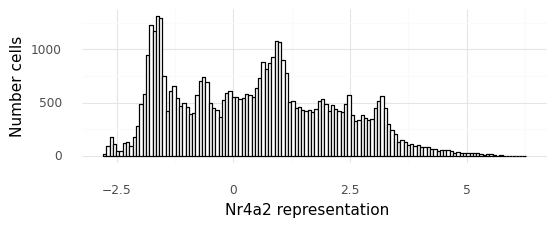

<ggplot: (-9223371866240358012)>

In [42]:
g = 'Nr4a2'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_representation)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.theme_minimal()
    + p.labs(x=f'{g} representation', y='Number cells')
)
plot_.save('10.pdf', verbose=False)
plot_

In [43]:
# Extract posterior frequencies of gene observations per cell

In [44]:
posterior_scales = full_posterior.sequential(batch_size=2000).get_sample_scale(gene_list=['Slc17a7', 'Olig1', 'Nr4a2'])

In [45]:
posterior_scales

,Nr4a2,Olig1,Slc17a7
0,0.000042,0.000002,0.000380
1,0.000043,0.000001,0.000520
2,0.000026,0.000004,0.000296
3,0.000060,0.000002,0.000432
4,0.000055,0.000002,0.000499
...,...,...,...
48261,0.000038,0.000004,0.000003
48262,0.000002,0.000007,0.000004
48263,0.000085,0.000004,0.000004
48264,0.000032,0.000139,0.000006


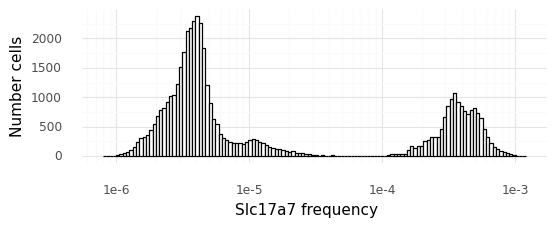

<ggplot: (-9223371866192214316)>

In [46]:
g = 'Slc17a7'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_scales)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} frequency', y='Number cells')
)
plot_.save('11.pdf', verbose=False)
plot_

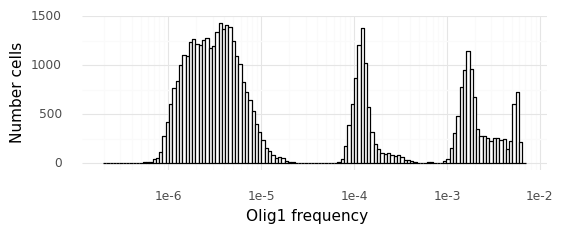

<ggplot: (-9223371866240143680)>

In [47]:
g = 'Olig1'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_scales)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} frequency', y='Number cells')
)
plot_.save('12.pdf', verbose=False)
plot_

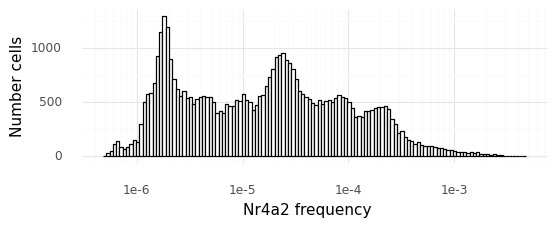

<ggplot: (-9223371866085101936)>

In [48]:
g = 'Nr4a2'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_scales)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} frequency', y='Number cells')
)
plot_.save('13.pdf', verbose=False)
plot_

In [49]:
# Extract the posterior expression rate (negative binomial mean parameter) for each cell and gene.

In [50]:
px_rates = []
for tensors in full_posterior.sequential():
    sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
    px_rate = full_posterior.model.get_sample_rate(
        sample_batch,
        batch_index=batch_index,
        y=label
    )
    px_rates.append(px_rate.detach().cpu().numpy()[..., gene_mask])

In [51]:
px_rates = np.vstack(px_rates)

In [52]:
px_rates.shape

(48266, 3)

In [53]:
posterior_rates = pd.DataFrame(px_rates, columns=full_posterior.gene_dataset.gene_names[gene_mask])

In [54]:
posterior_rates

,Nr4a2,Olig1,Slc17a7
0,0.771996,0.028941,6.225684
1,0.644585,0.022842,7.755132
2,0.359843,0.047942,4.879290
3,0.653054,0.035617,6.294482
4,1.054332,0.030629,9.767954
...,...,...,...
48261,0.029879,0.004151,0.002199
48262,0.001518,0.005346,0.003561
48263,0.037214,0.004366,0.002821
48264,0.024713,0.129953,0.005499


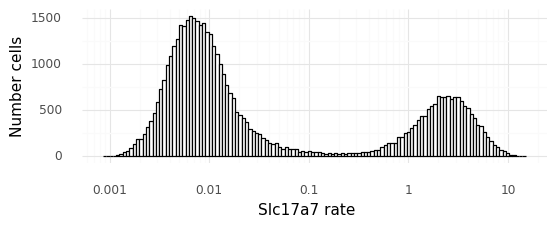

<ggplot: (-9223371866240323668)>

In [55]:
g = 'Slc17a7'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_rates)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} rate', y='Number cells')
)
plot_.save('14.pdf', verbose=False)
plot_

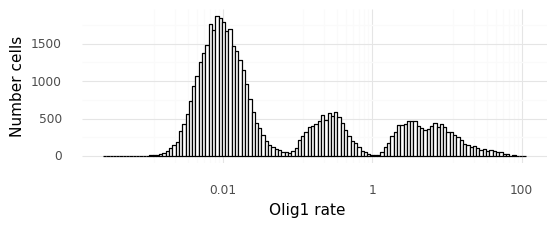

<ggplot: (-9223371865938605984)>

In [71]:
g = 'Olig1'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_rates)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} rate', y='Number cells')
)
plot_.save('15.pdf', verbose=False)
plot_

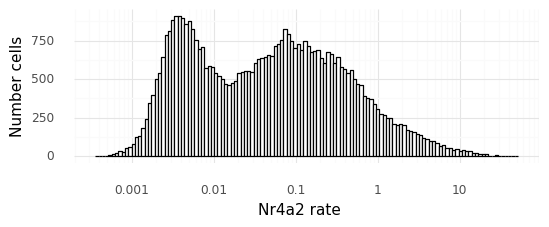

<ggplot: (-9223371866070769592)>

In [57]:
g = 'Nr4a2'

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x=f'{g}'), posterior_rates)
    + p.geom_histogram(bins=128, color='k', fill='w')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} rate', y='Number cells')
)
plot_.save('16.pdf', verbose=False)
plot_

In [58]:
# Sample UMI counts from the posterior

In [59]:
from scvi.models.distributions import NegativeBinomial

In [60]:
sample_counts = []
for tensors in full_posterior.sequential(batch_size=2000):
    sample_batch, _, _, batch_index, labels = tensors
    outputs = full_posterior.model.inference(
        sample_batch,
        batch_index=batch_index,
        y=labels
    )
    
    px_r = outputs["px_r"]
    px_rate = outputs["px_rate"]
    px_dropout = outputs["px_dropout"]
    
    dist = NegativeBinomial(mu=px_rate[..., gene_mask], theta=px_r[gene_mask])
    
    sample_counts.append(dist.sample().cpu().numpy())
    
sample_counts = np.vstack(sample_counts)

sample_counts = pd.DataFrame(sample_counts, columns=full_posterior.gene_dataset.gene_names[gene_mask])

In [61]:
sample_counts

,Nr4a2,Olig1,Slc17a7
0,1.0,0.0,4.0
1,0.0,0.0,4.0
2,0.0,0.0,13.0
3,0.0,0.0,6.0
4,1.0,0.0,5.0
...,...,...,...
48261,0.0,0.0,0.0
48262,0.0,0.0,0.0
48263,0.0,0.0,0.0
48264,0.0,0.0,0.0


C:\Users\vale\Anaconda3\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)


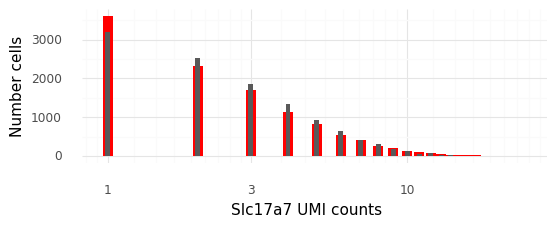

<ggplot: (-9223371866085354548)>

In [62]:
g = 'Slc17a7'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})
sample_count_hist = sample_counts[f'{g}'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(
        p.aes(y=f'{g}'), stat='identity', data=sample_count_hist.query('0 < counts < 25'),
        fill='red',
        width=0.033
    )
    + p.geom_bar(stat='identity')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)
plot_.save('17.pdf', verbose=False)
plot_

C:\Users\vale\Anaconda3\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)


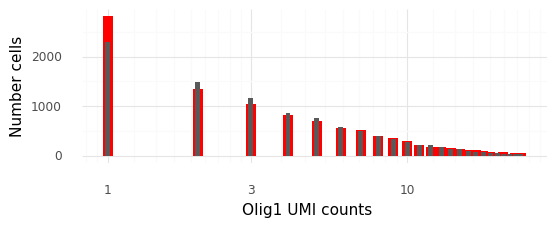

<ggplot: (-9223371866193142968)>

In [63]:
g = 'Olig1'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})
sample_count_hist = sample_counts[f'{g}'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(
        p.aes(y=f'{g}'), stat='identity', data=sample_count_hist.query('0 < counts < 25'),
        fill='red',
        width=0.033
    )
    + p.geom_bar(stat='identity')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)
plot_.save('18.pdf', verbose=False)
plot_

C:\Users\vale\Anaconda3\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\positions\position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)


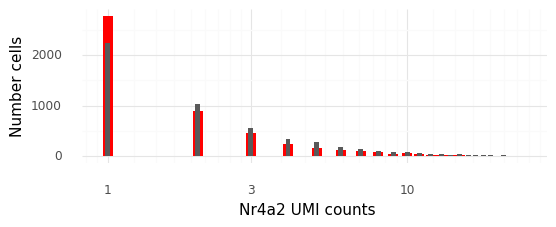

<ggplot: (-9223371865938606032)>

In [64]:
g = 'Nr4a2'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})
sample_count_hist = sample_counts[f'{g}'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(
        p.aes(y=f'{g}'), stat='identity', data=sample_count_hist.query('0 < counts < 25'),
        fill='red',
        width=0.033
    )
    + p.geom_bar(stat='identity')
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)
plot_.save('19.pdf', verbose=False)
plot_

In [65]:
gene_list = ['Slc17a7', 'Olig1', 'Nr4a2']

sample_count_hist_dict = {g: [] for g in gene_list}

for i in range(10):
    sample_counts = []
    for tensors in full_posterior.sequential(batch_size=2000):
        sample_batch, _, _, batch_index, labels = tensors
        outputs = full_posterior.model.inference(
            sample_batch,
            batch_index=batch_index,
            y=labels
        )

        px_r = outputs["px_r"]
        px_rate = outputs["px_rate"]
        px_dropout = outputs["px_dropout"]

        dist = NegativeBinomial(mu=px_rate[..., gene_mask], theta=px_r[gene_mask])

        sample_counts.append(dist.sample().cpu().numpy())

    sample_counts = np.vstack(sample_counts)

    sample_counts = pd.DataFrame(sample_counts, columns=full_posterior.gene_dataset.gene_names[gene_mask])

    for g in gene_list:
        sample_count_hist = sample_counts[f'{g}'].value_counts().reset_index().rename(columns={'index': 'counts'})

        sample_count_hist_dict[g].append(sample_count_hist)

In [66]:
for g in sample_count_hist_dict:
    sample_count_hist_dict[g] = pd.concat(sample_count_hist_dict[g])

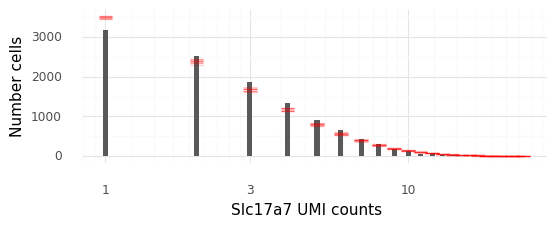

<ggplot: (-9223371866235990728)>

In [67]:
g = 'Slc17a7'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(stat='identity')
    + p.geom_point(
        p.aes(y=f'{g}'),
        data=sample_count_hist_dict[g].query('0 < counts < 25'),
        fill='red',
        shape='_',
        size=5,
        alpha=0.2
    )
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)
plot_.save('20.pdf', verbose=False)
plot_

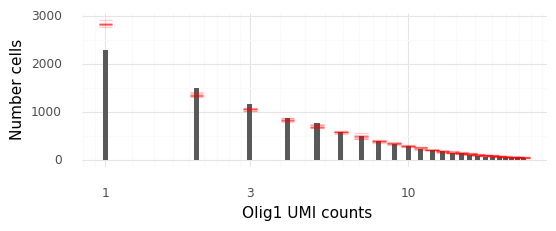

<ggplot: (-9223371865938560900)>

In [68]:
g = 'Olig1'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(stat='identity')
    + p.geom_point(
        p.aes(y=f'{g}'),
        data=sample_count_hist_dict[g].query('0 < counts < 25'),
        fill='red',
        shape='_',
        size=5,
        alpha=0.2
    )
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)
plot_.save('21.pdf', verbose=False)
plot_

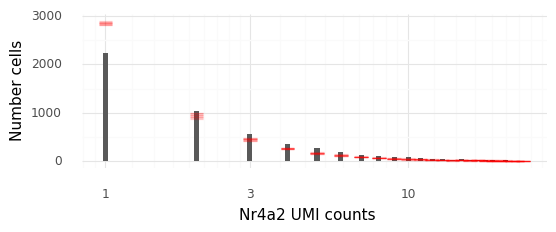

<ggplot: (-9223371866192290780)>

In [69]:
g = 'Nr4a2'

count_hist = adata.obs[f'{g}_counts'].value_counts().reset_index().rename(columns={'index': 'counts'})

p.options.figure_size = 6, 2
plot_ = (
    p.ggplot(p.aes(x='counts', y=f'{g}_counts'), count_hist.query('0 < counts < 25'))
    + p.geom_bar(stat='identity')
    + p.geom_point(
        p.aes(y=f'{g}'),
        data=sample_count_hist_dict[g].query('0 < counts < 25'),
        fill='red',
        shape='_',
        size=5,
        alpha=0.2
    )
    + p.scale_x_log10()
    + p.theme_minimal()
    + p.labs(x=f'{g} UMI counts', y='Number cells')
)
plot_.save('22.pdf', verbose=False)
plot_